In [1]:
import networkx as nx
import pickle
from multiprocessing import Pool

import numpy as np; np.set_printoptions(suppress=True, linewidth=180); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt
from scipy.linalg import expm

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset, plot_twocomponent_results, plot_onecomponent_results
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph
from analyse_simulation import two_component_statistics, one_component_statistics

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping, simulate_langevin_em

In [2]:
def integral_from_point(f, x, point_x):
    positive_integral = [np.trapz(f[point_x:i], pop_val[point_x:i]) for i in range(point_x, len(x))]
    negative_integral = np.array([np.trapz(-f[(point_x-i):point_x][::-1], x[(point_x-i):point_x][::-1]) for i in range(0, point_x)])[::-1]
    integral = list(negative_integral)
    integral.extend(positive_integral)
    return np.array(integral)

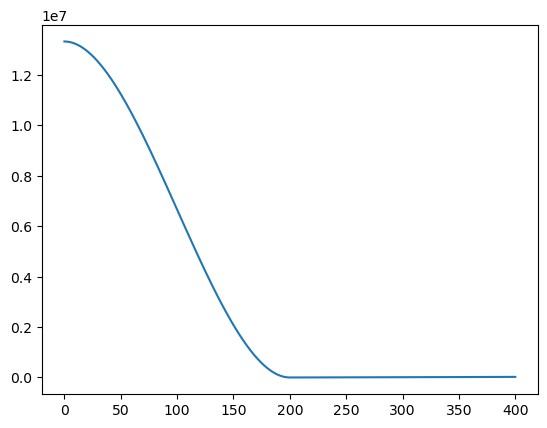

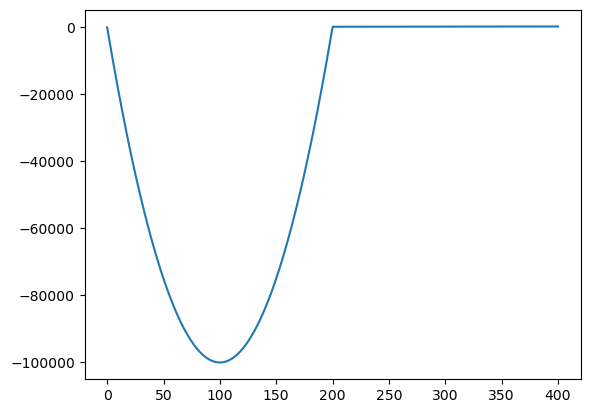

In [3]:
NSS = 200.0
Birth = 0.4
Death = 0.4
c = 10.0

def return_strength(pop, c):
    return (pop*(max(0, Birth+(c*(NSS-pop)))-Death))

pop_val = np.linspace(0, 400, 10001)
center_i = np.where(pop_val == NSS)[0][0]
abs_net_change = np.array([abs(return_strength(pop, c)) for pop in pop_val])
integral = integral_from_point(abs_net_change, pop_val, center_i)
plt.plot(pop_val, integral)
plt.show()
gradient = np.gradient(integral, pop_val)

plt.plot(pop_val, gradient)

In [4]:
# c = 0.00001
# D_estimated = 85.0



# def potential_gradient(x, c):
#     # Replace this with the gradient of your potential energy function
#     return -(x*(max(0, Birth+(c*(NSS-x)))-Death))

# def simulate_OU(alpha, D, x0, dt, T, c):
#     n = int(T / dt)
#     x = np.zeros(n)
    
#     # precompute the brownian motion component
#     brownian_arr = np.sqrt(2*D) * np.sqrt(dt) * np.random.randn(n)
    
#     x[0] = x0
#     for i in range(1, n):
#         #dW = np.sqrt(dt) * randn_arr[i]
#         x[i] = x[i-1] - (alpha*potential_gradient(x[i-1], c)*dt) + (brownian_arr[i])
#         if x[i] <= 0:
#             break
            
#     x = np.array(x)[::10]
#     return x

# def wrapper(args):
#     return simulate_OU(*args)

# def parallel_simulation(rep, alpha, D, x0, dt, T, c):
#     with Pool(10) as pool:
#         # Package arguments for each simulation into a list of tuples
#         args = [(alpha, D, x0, dt, T, c_b) for _ in range(rep)]
#         # Execute simulations in parallel
#         results = pool.map(wrapper, args)

#     return np.array(results)

In [5]:



# C_B_val = [0.0]

# print(f"preparing to simulate with the following parameters:")
# print(C_B_val, '\n')

# for c_b in C_B_val:
#     print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
#     # Parameters
#     alpha = 1
#     D = 75.0

#     x0 = NSS
#     T = 5.0
#     dt = 0.01

#     rep = 500
#     x_res = parallel_simulation(rep, alpha, D, x0, dt, T, c_b)
    
#     x = np.mean(x_res, axis = 0)
#     x_sem = np.nanstd(x_res, axis = 0)/np.sqrt(rep)
    
#     t = np.arange(0, T, dt*10)

#     plt.plot(t, x)
#     plt.fill_between(t, x-(2*x_sem), x+(2*x_sem), alpha = 0.5)
#     plt.xlabel('Time')
#     plt.ylabel('Copy number')
#     plt.title('Ornstein-Uhlenbeck Process')
#     plt.show()

#     print(np.round(np.mean(x[-100:-1]    ), 2))
#     print(np.round(x_sem[-1], 2))
    
    

In [6]:
# T = 50.0
# TIME_POINTS = np.linspace(0, T, 101)
# alpha = 1.0
# c = 0.0
# ou_param = {
#     'birthrate': Birth,
#     'deathrate': Death,
#     'NSS': NSS,
#     'c_b': c,
#     'D': D_estimated,
#     'alpha':alpha
# }

# rep = 100000
# x_res = simulate_ou(ou_param, TIME_POINTS, start_state = NSS, 
#                     replicates = rep,
#                     timestep = 0.01
#                    )
    
# x = np.mean(x_res, axis = 0)
# x_sem = np.nanstd(x_res, axis = 0)/np.sqrt(rep)


# plt.plot(TIME_POINTS, x)
# plt.fill_between(TIME_POINTS, x-(2*x_sem), x+(2*x_sem), alpha = 0.5)
# plt.xlabel('Time') 
# plt.ylabel('Copy number')
# plt.title('Ornstein-Uhlenbeck Process')
# plt.show()

# print(np.round(np.mean(x[-100:-1]    ), 2))
# print(np.round(x_sem[-1], 2))

In [7]:
def CTMC_approx(K, C, NSS, time_points):
    print("numerical calculation of CTMC approximation...")
    
    def birth_rate(n):
        return n*max(0.0, K+(C*(NSS-n)))
    def death_rate(n):
        return n*K

    # plot birth rates over pop size
    pop_range = np.arange(0, 100000)
    birth_rates = np.array([birth_rate(pop) for pop in pop_range])
    zero_births = np.where(birth_rates == 0)[0][1]
    
    if zero_births > 5000:
        return None

    init_state = NSS
    state_start = 0
    state_end = zero_births

    state_range = 1+state_end-state_start
    states = np.array([i for i in range(state_start, state_end+1)])

    # get transition rate matrix Q
    Q = np.zeros((state_range, state_range), dtype = np.float64)
    for i in range(state_range):
        for j in range(state_range):
            # get rate, depending on birth or death or neither
            rate = 0
            if i+1 == j:
                rate = birth_rate(state_start+i)
            elif i-1 == j:
                rate = death_rate(state_start+i)
            Q[i,j] = rate
        # make rows sum to 0
    for i in range(state_range):
        Q[i, i] = -np.sum(Q[i,:])
    Q[0, 0] = 0


    # inital distribution of states
    N_0 = np.zeros(state_range)
    N_0[int(init_state)] = 1 # set the intial distribution to be all NSS

    pop_size = []
    time_steps = np.linspace(0, T+1, 100)
    for i, t in enumerate(time_points):
        # get transition probability matrix P(t) 
        P_t = expm(Q*t)
        
        # distribution of states at time t
        N_t = N_0 @ P_t

        # expected value at time t
        E_N_t = np.average(states, weights=N_t)

        pop_size.append(E_N_t)
        print(f'Transition rate matrix calculation {round(((i+1)/len(time_points))*100, 2)}% complete     ', end = '\r')
    print("")    
    return np.array(pop_size)

In [8]:
NSS = 200.0
K = 0.005

T = 750

preparing to simulate with the following parameters:
[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06, 5e-07, 1e-07, 5e-08, 1e-08, 5e-09] 


<<<< STARTING SIMULATION WITH C_B = 0.1 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 15533.71it/s]


200.0
0.0


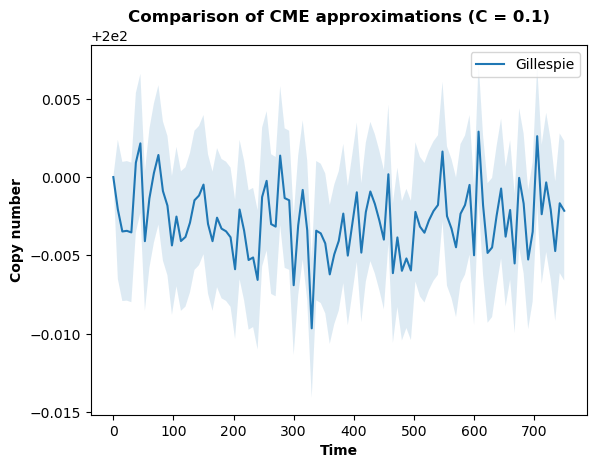


<<<< STARTING SIMULATION WITH C_B = 0.05 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 15055.21it/s]


199.99
0.0


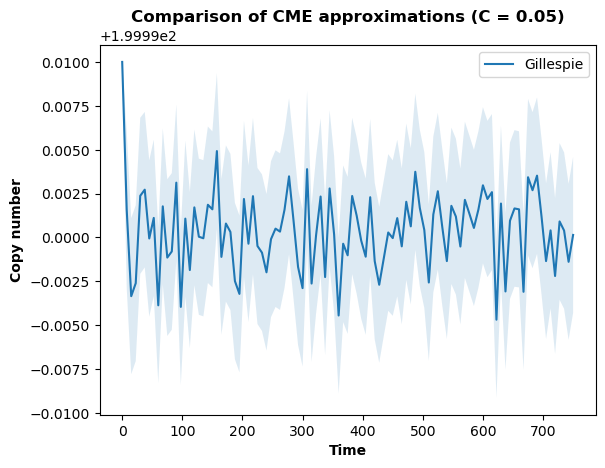


<<<< STARTING SIMULATION WITH C_B = 0.01 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 15067.46it/s]


199.88
0.0


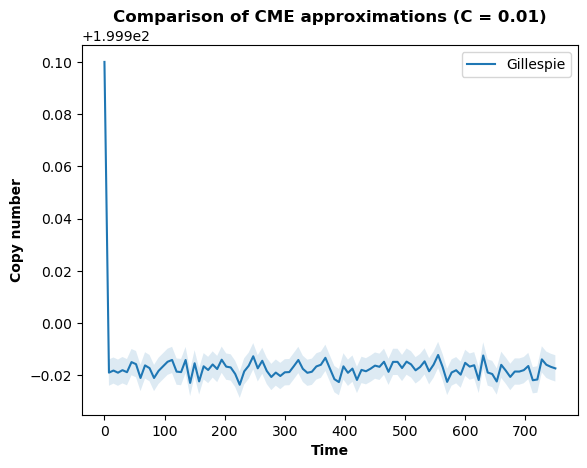


<<<< STARTING SIMULATION WITH C_B = 0.005 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14792.88it/s]


199.73
0.0


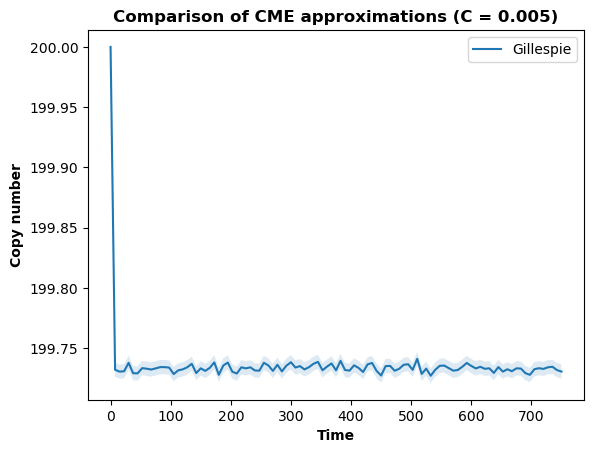


<<<< STARTING SIMULATION WITH C_B = 0.001 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 15168.24it/s]


199.92
0.01


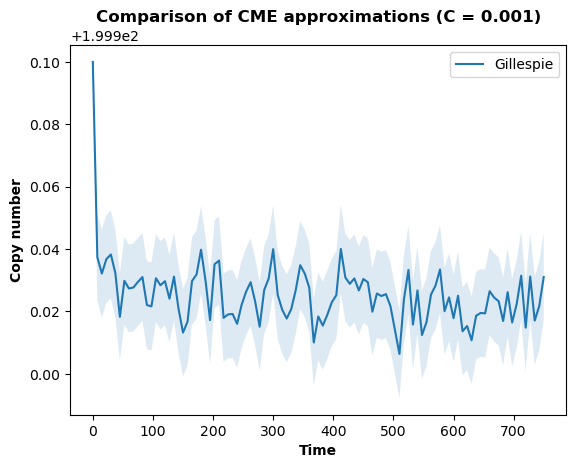


<<<< STARTING SIMULATION WITH C_B = 0.0005 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14770.45it/s]


199.92
0.01


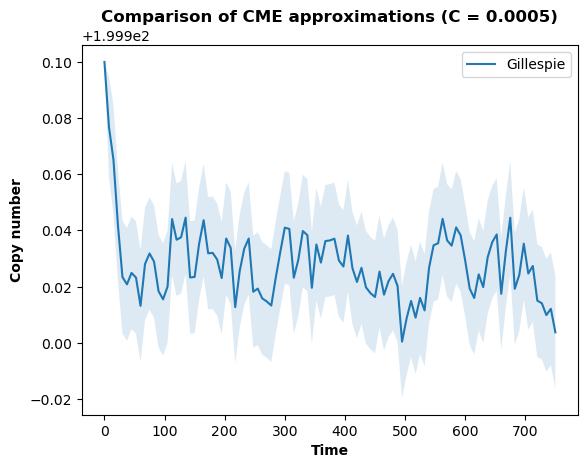


<<<< STARTING SIMULATION WITH C_B = 0.0001 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14991.19it/s]


199.74
0.02


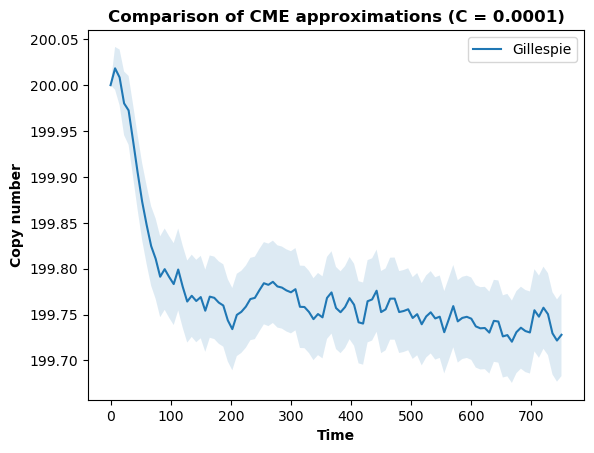


<<<< STARTING SIMULATION WITH C_B = 5e-05 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 15033.05it/s]


199.48
0.03


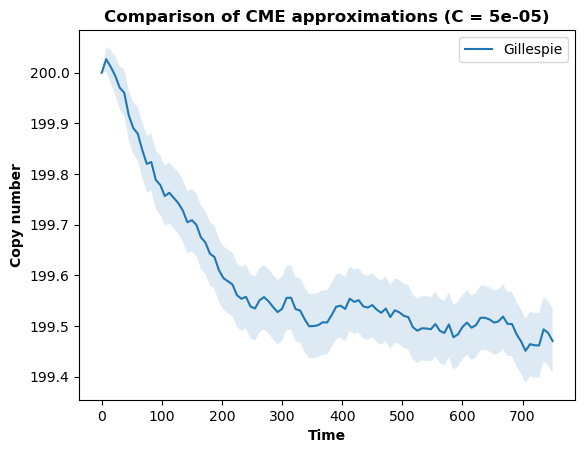


<<<< STARTING SIMULATION WITH C_B = 1e-05 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14985.32it/s]


198.52
0.07


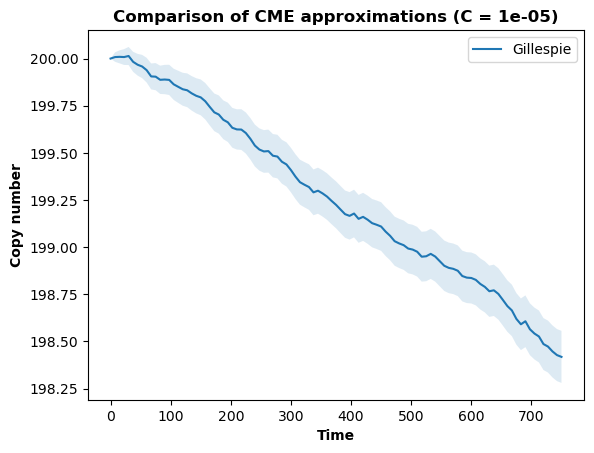


<<<< STARTING SIMULATION WITH C_B = 5e-06 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14973.97it/s]


198.72
0.09


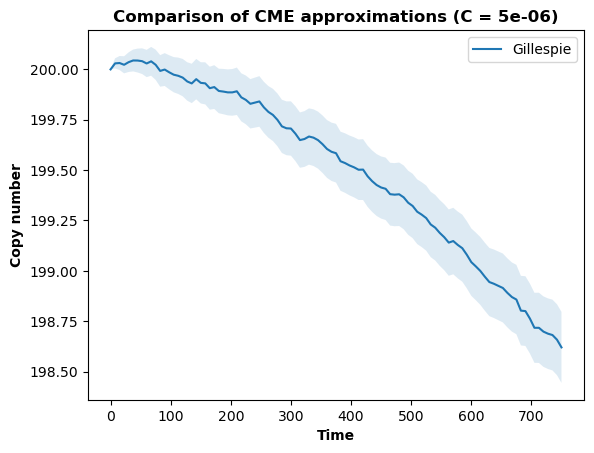


<<<< STARTING SIMULATION WITH C_B = 1e-06 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14874.53it/s]


199.41
0.11


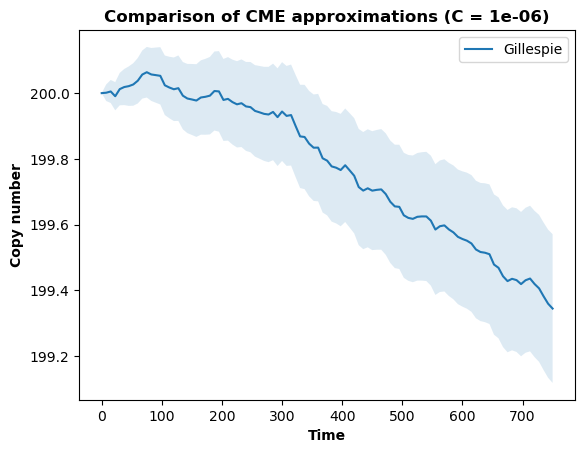


<<<< STARTING SIMULATION WITH C_B = 5e-07 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14899.81it/s]


199.71
0.12


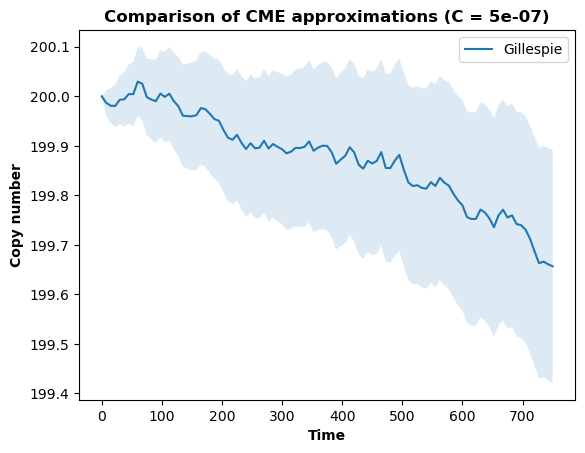


<<<< STARTING SIMULATION WITH C_B = 1e-07 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14813.51it/s]


199.94
0.12


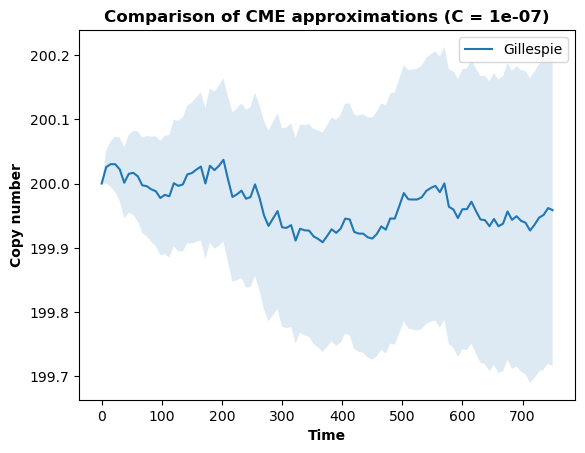


<<<< STARTING SIMULATION WITH C_B = 5e-08 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14894.19it/s]


200.05
0.12


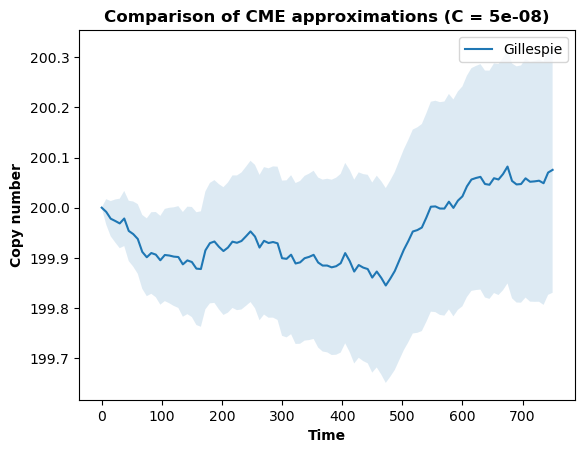


<<<< STARTING SIMULATION WITH C_B = 1e-08 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14914.52it/s]


200.07
0.12


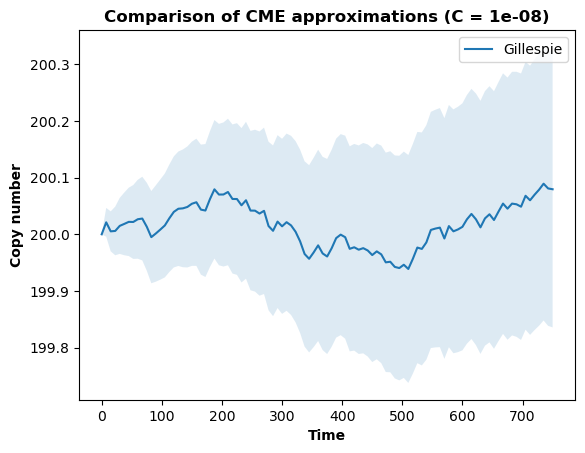


<<<< STARTING SIMULATION WITH C_B = 5e-09 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [00:06<00:00, 14631.85it/s]


199.94
0.12


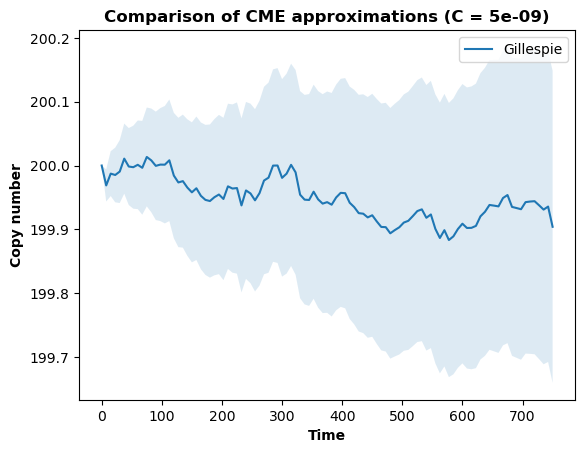

In [15]:
C_B_val = sequence = [round(i * 10**-decimals, 14) for decimals in range(2, 10) for i in range(10, 0, -1)]
C_B_val = [element for i, element in enumerate(C_B_val) if i % 5 == 0] # sparseify for testing
    


TIME_POINTS = np.linspace(0, T, 101)

REP = 100000
    
print(f"preparing to simulate with the following parameters:")
print(C_B_val, '\n')

for c_b in C_B_val:
    print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
    
    
     ## GILLESPIE SECTION
    
    G = load_pickled_neuron_graph(f'neuron_graphs/model_1node.pkl')
    for node, data in G.nodes(data = True):
        if data['nodetype'] == 1:
            data['delta'] = 0.25
            data['c_b'] = c_b
        data['nss'] = NSS
        data['death_rate'] = K
        data['birth_rate'] = K

    VARS, NODES = names_from_network(G)
    START_STATE = start_state_from_nodes(G, heteroplasmy=0.0, delta=0.25)

    SDE_PARAM = sde_param_from_network(G, prnt=False)
    
    
    gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP)
    
    c_g = np.mean(gillespie_results[:,0,:], axis = 0)
    c_g_sem = np.nanstd(gillespie_results[:,0,:], axis = 0)/np.sqrt(REP)
    print(np.round(np.mean(c_g[-10:-1]    ), 2))
    print(np.round(c_g_sem[-1], 2))
    
#     ## TAU LEAPING SECTION
    
#     tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP, timestep=0.001)
    
#     c_t = np.mean(tauleaping_results[:,0,:], axis = 0)
#     c_t_sem = np.nanstd(tauleaping_results[:,0,:], axis = 0)/np.sqrt(REP)
#     print(np.round(np.mean(c_t[-10:-1]    ), 2))
#     print(np.round(c_t_sem[-1], 2))
    
#     ## OU SECTION
#     langevin_param = {
#         'birthrate': K,
#         'deathrate': K,
#         'NSS': NSS,
#         'c_b': c_b,
#     }
    
#     langevin_res = simulate_langevin_em(langevin_param, TIME_POINTS, start_state=NSS, replicates = REP, timestep = 0.001)
    
#     c_l = np.mean(langevin_res, axis = 0)
#     c_l_sem = np.nanstd(langevin_res, axis = 0)/np.sqrt(REP)
#     print(np.round(np.mean(c_l[-10:-1]    ), 2))
#     print(np.round(c_l_sem[-1], 2))
    
#     ## CTMC SECTION
#     c_c = CTMC_approx(K, c_b, NSS, TIME_POINTS)
    
#     print(np.round(np.mean(c_c[-10:-1]    ), 2))
    
    ## PLOT
    plt.plot(TIME_POINTS, c_g, label = 'Gillespie')
    plt.fill_between(TIME_POINTS, c_g-(2*c_g_sem), c_g+(2*c_g_sem), alpha = 0.15)
    
#     plt.plot(TIME_POINTS, c_t, label = 'Tau leaping')
#     plt.fill_between(TIME_POINTS, c_t-(2*c_t_sem), c_t+(2*c_t_sem), alpha = 0.15)
    
#     plt.plot(TIME_POINTS, c_l, label = 'Langevin')
#     plt.fill_between(TIME_POINTS, c_l-(2*c_l_sem), c_l+(2*c_l_sem), alpha = 0.15)
    
    # plt.plot(TIME_POINTS, c_c, label = 'CTMC', color = 'k', linestyle = 'dashed')
    
    plt.xlabel('Time', weight = 'bold') 
    plt.ylabel('Copy number', weight = 'bold')
    plt.title(f'Comparison of CME approximations (C = {c_b})', weight = 'bold')
    plt.legend()
    plt.show()

    # print(np.round(np.mean(x[-100:-1]    ), 2))
    # print(np.round(x_sem[-1], 2))

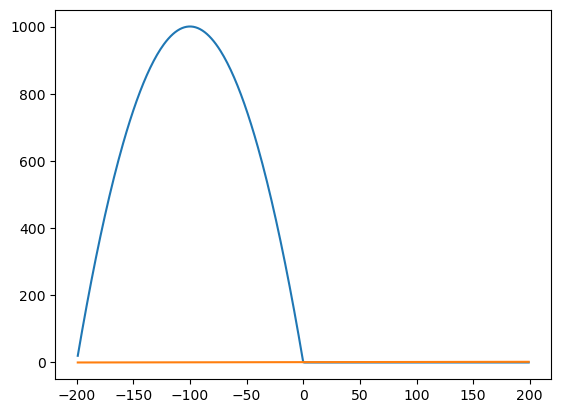

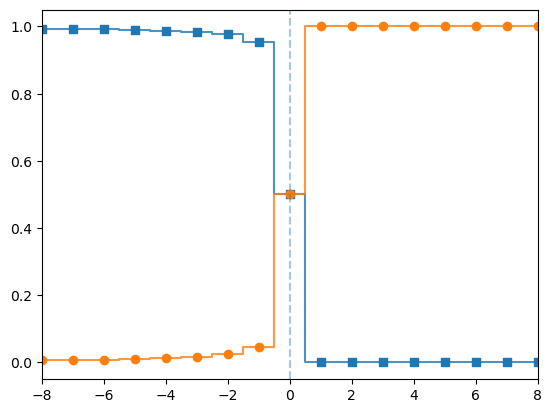

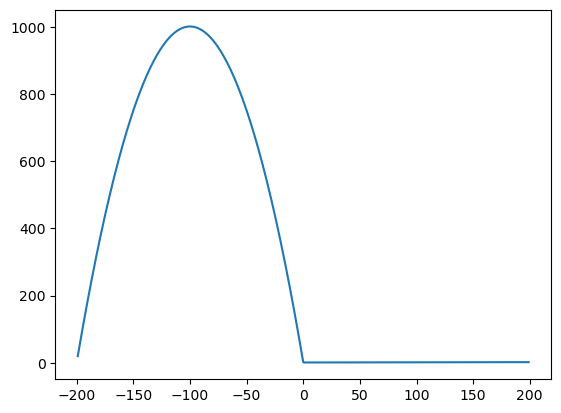

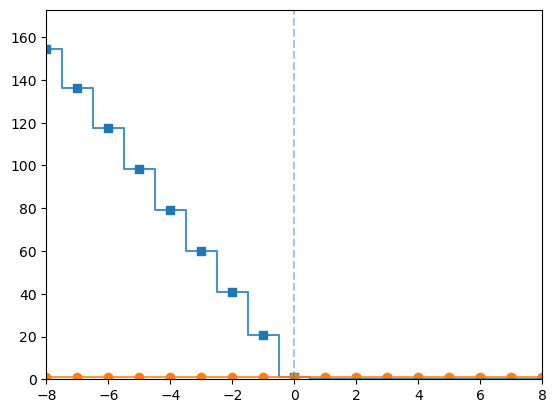

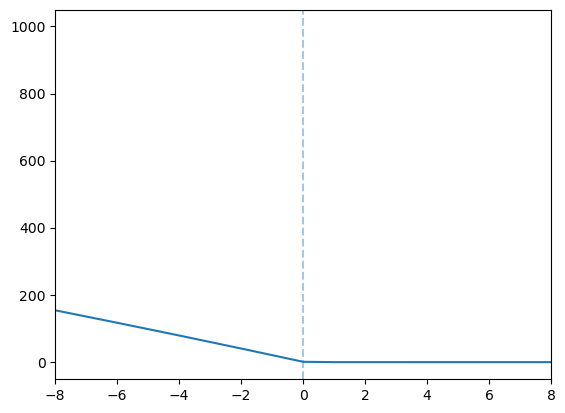

In [10]:
c = 0.1
x = int(NSS); y = 20

def p_b_d(y):
    p_b = (x+y)*max(0, K+(c*(NSS-(NSS+y))))
    p_d = (x+y)*K
    return p_b, p_d

pop_diff = np.arange(-199, 200, 1)

r_p_b = np.array([p_b_d(diff)[0] for diff in pop_diff])
r_p_d = np.array([p_b_d(diff)[1] for diff in pop_diff])
plt.plot(pop_diff, r_p_b)
plt.plot(pop_diff, r_p_d)
plt.show()


r_p_b_r = np.array([p_b_d(diff)[0]/(p_b_d(diff)[0]+p_b_d(diff)[1]) for diff in pop_diff])
r_p_d_r = np.array([p_b_d(diff)[1]/(p_b_d(diff)[0]+p_b_d(diff)[1]) for diff in pop_diff])
plt.step(pop_diff, r_p_b_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, r_p_b_r, marker = 's' )
plt.step(pop_diff, r_p_d_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, r_p_d_r)
plt.axvline(0, alpha = 0.4, linestyle='dashed')
plt.xlim([-8, 8])
plt.show()

sampling_rate = (r_p_b+r_p_d)
plt.plot(pop_diff, sampling_rate)
plt.show()

f_r_p_b_r = sampling_rate*r_p_b_r
f_r_p_d_r = sampling_rate*r_p_d_r
plt.step(pop_diff, f_r_p_b_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, f_r_p_b_r, marker = 's' )
plt.step(pop_diff, f_r_p_d_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, f_r_p_d_r)
plt.axvline(0, alpha = 0.4, linestyle='dashed')
plt.xlim([-8, 8])
plt.ylim([0, max([np.max(f_r_p_b_r[x-10:x+10]), np.max(f_r_p_d_r[x-10:x+10])])])
plt.show()

plt.plot(pop_diff, r_p_b-r_p_d)
plt.axvline(0, alpha = 0.4, linestyle='dashed')
plt.xlim([-8, 8])
plt.show()

# plt.plot(integral_from_point(r_p_b, pop_diff, NSS))
# plt.plot(integral_from_point(r_p_d, pop_diff, NSS))